In [1]:
import sys
sys.path.append('../')
import numpy as np
import torch
import matplotlib.pyplot as plt

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, expect_val_dm
from torchqc.operators import DynamicOperator
from torchqc.common_matrices import sigmaZ, annihilation, creation, eye, sigmaPlus, sigmaMinus
from torchqc.dynamics import lindblad_equation
from torchqc.tensor_product import tensor_product_ops, tensor_product_states

* Start from basis state $\psi_0 \otimes \ket{1}$

In [2]:
n = 2 # two level atom
N = 15 # number of fock states
total_dims = n * N

# initially atom state is in excited state
basis_states = QuantumState.basis(n)
atom_state = basis_states[1]

fock_state = QuantumState.basis(N)[0]

initial_state = tensor_product_states(fock_state, atom_state)

* Simulate dynamics with TorchQc

In [3]:
T = 25
Dt = 0.01
wc = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # atom frequency
g = 0.05 * 2 * np.pi  # coupling strength
kappa = 0.005  # cavity dissipation rate
gamma = 0.05  # atom dissipation rate
n_th_a = 0.0  # avg number of thermal bath excitation

time = np.arange(0, T, Dt, dtype = np.float32)

* Quantum Rabi model

In [4]:
a_dagger = creation(N)
a = annihilation(N)
sigmap = sigmaPlus()
sigmam = sigmaMinus()

H1 = tensor_product_ops(eye(N), -(wa / 2) * sigmaZ())
H2 = tensor_product_ops(wc * a_dagger * a, eye(n))
H3 = g * tensor_product_ops(a + a_dagger, sigmap + sigmam)
H = H1 + H2 + H3

In [5]:
hamiltonian = DynamicOperator(total_dims, H, time=time)

In [6]:
jump_ops = []
rates = []

# cavity relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    jump_ops.append(tensor_product_ops(a, eye(n)))
    rates.append(rate)

# cavity excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    jump_ops.append(tensor_product_ops(a.dag(), eye(2)))
    rates.append(rate)

# qubit relaxation
rate = gamma
if rate > 0.0:
    jump_ops.append(tensor_product_ops(eye(N), sigmam))
    rates.append(rate)

* Simulate dynamics with von-Neumann equations

In [7]:
rho = get_density_matrix(initial_state)
time_tensor, states = lindblad_equation(rho, hamiltonian, time, Dt, jump_ops, rates, method="rk4")

In [8]:
N_op = a_dagger * a
expectation_values = expect_val_dm(states, tensor_product_ops(eye(N), sigmam.dagger().opmul(sigmam)))
expectation_values2 = expect_val_dm(states, tensor_product_ops(N_op, eye(n)))

* Simulate dynamics with Qutip

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, basis, destroy, mesolve, ptrace, qeye,
                   tensor, wigner, anim_wigner, sigmaz)
# set a parameter to see animations in line
from matplotlib import rc
rc('animation', html='jshtml')

%matplotlib inline

In [10]:
wc = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # atom frequency
g = 0.05 * 2 * np.pi  # coupling strength
kappa = 0.005  # cavity dissipation rate
gamma = 0.05  # atom dissipation rate
N = 15  # number of cavity fock states
n_th_a = 0.0  # avg number of thermal bath excitation
use_rwa = False

tlist = np.linspace(0, 25, 101)

In [11]:
# intial state
psi0 = tensor(basis(N, 0), basis(2, 1))  # start with an excited atom

# operators
a = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))

# Hamiltonian
H = wc * a.dag() * a + wa * sm.dag() * sm + \
    g * (a.dag() + a) * (sm + sm.dag())

In [12]:
c_ops = []

# cavity relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a)

# cavity excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a.dag())

# qubit relaxation
rate = gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm)

In [13]:
output = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm])

* Compare the two framework results

Text(0.5, 1.0, 'Vacuum Rabi oscillations')

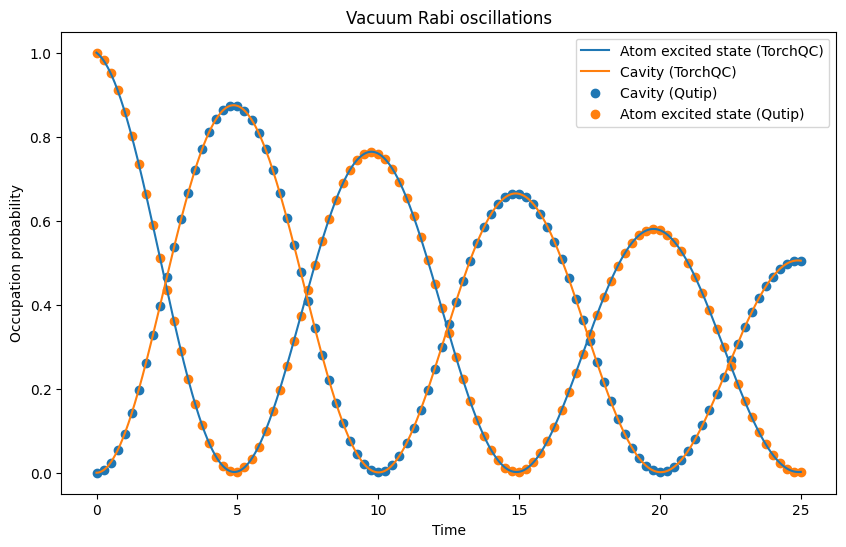

In [14]:
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.plot(time, expectation_values, label="Atom excited state (TorchQC)")
axes.plot(time, expectation_values2, label="Cavity (TorchQC)")

axes.scatter(tlist, n_c, label="Cavity (Qutip)")
axes.scatter(tlist, n_a, label="Atom excited state (Qutip)")

axes.legend(loc=0)
axes.set_xlabel("Time")
axes.set_ylabel("Occupation probability")
axes.set_title("Vacuum Rabi oscillations")